Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6915 entries, 0 to 6914
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Study          6915 non-null   object 
 1   Subject        6915 non-null   object 
 2   Class          6915 non-null   int64  
 3   UPDRS          6915 non-null   float64
 4   Jitter         6915 non-null   float64
 5   Jitter(Abs)    6915 non-null   float64
 6   Jitter:RAP     6915 non-null   float64
 7   Jitter:PPQ5    6915 non-null   float64
 8   Jitter:DDP     6915 non-null   float64
 9   Shimmer        6915 non-null   float64
 10  Shimmer(dB)    6915 non-null   float64
 11  Shimmer:APQ3   6915 non-null   float64
 12  Shimmer:APQ5   6915 non-null   float64
 13  Shimmer:APQ11  6915 non-null   float64
 14  Shimmer:DDA    6915 non-null   float64
 15  NHR            6915 non-null   float64
 16  HNR            6915 non-null   float64
dtypes: float64(14), int64(1), objec

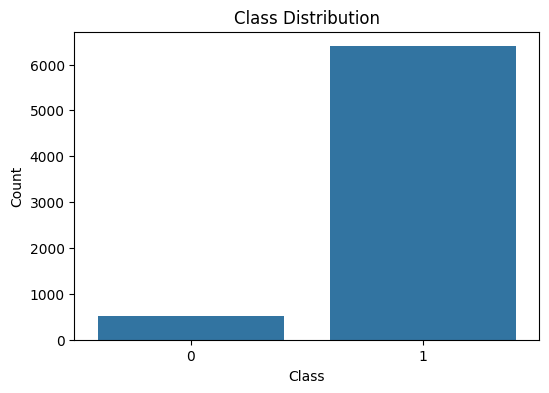

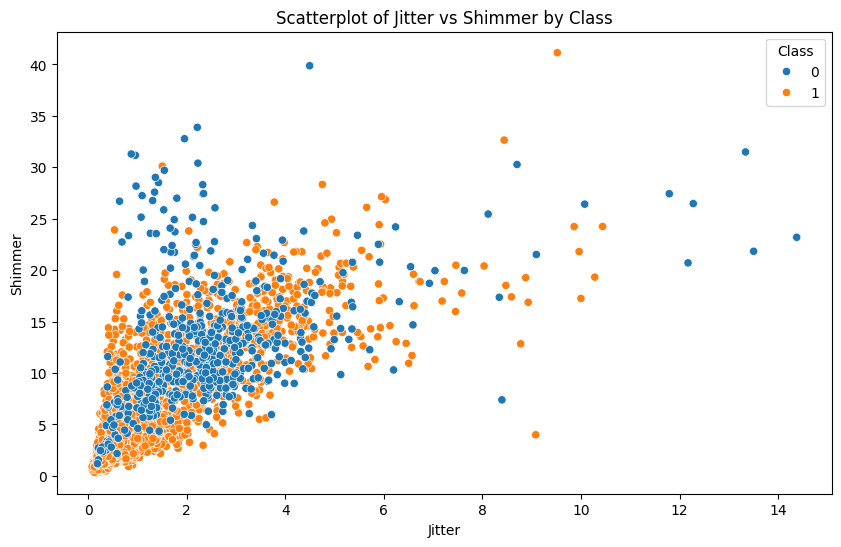

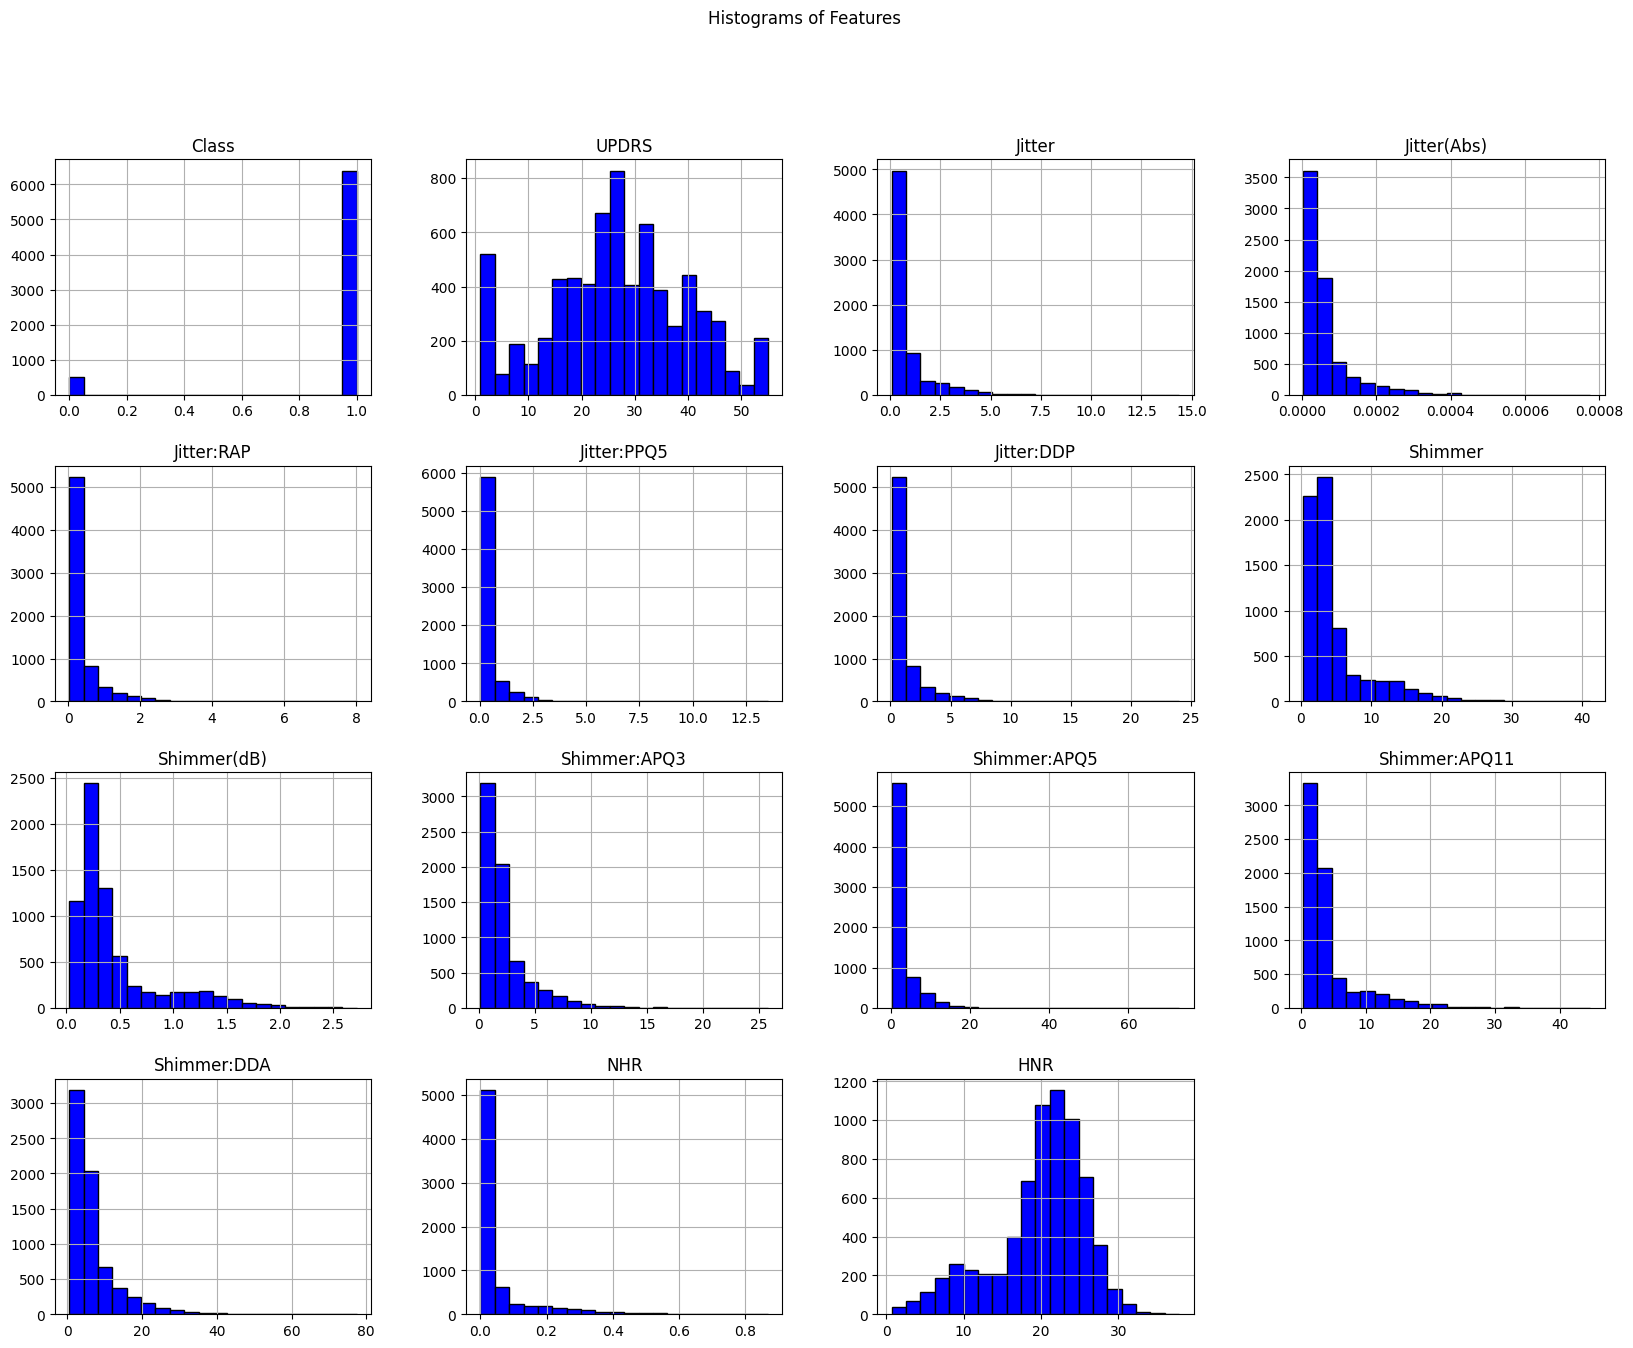

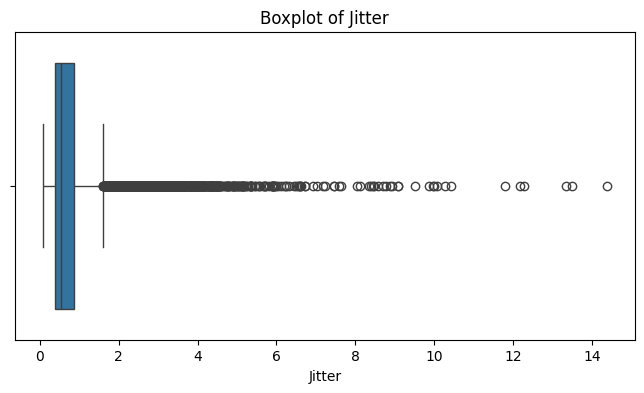

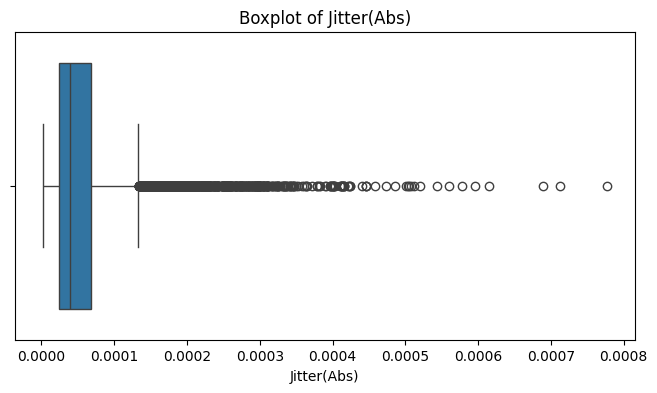

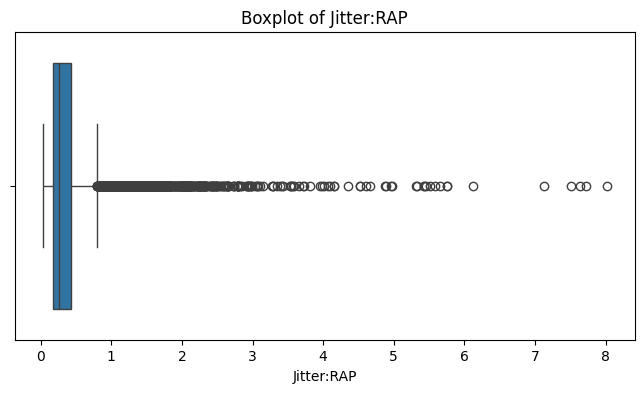

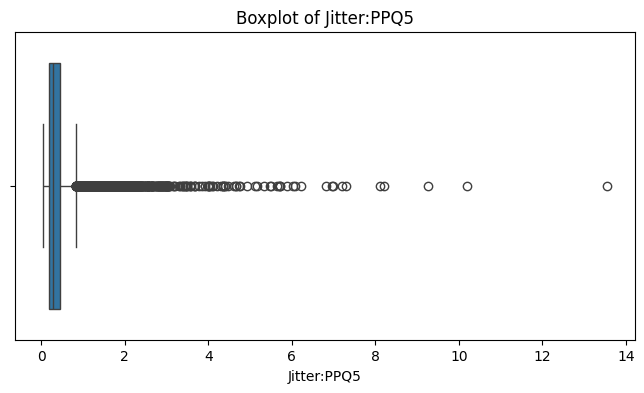

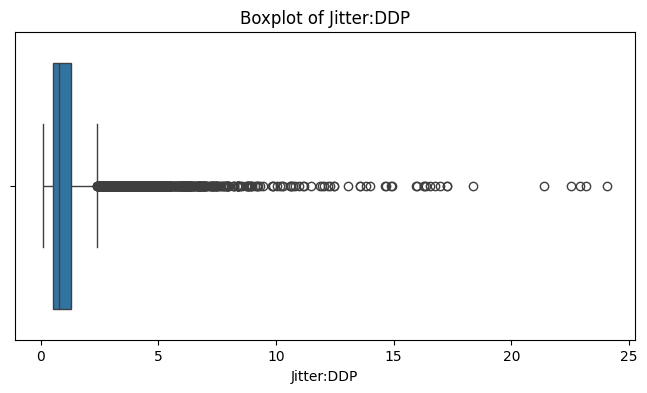

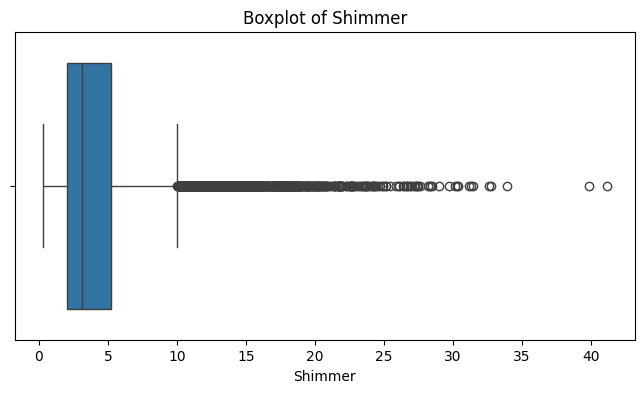

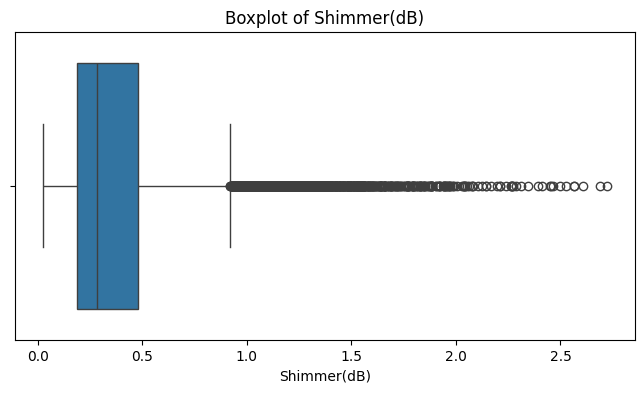

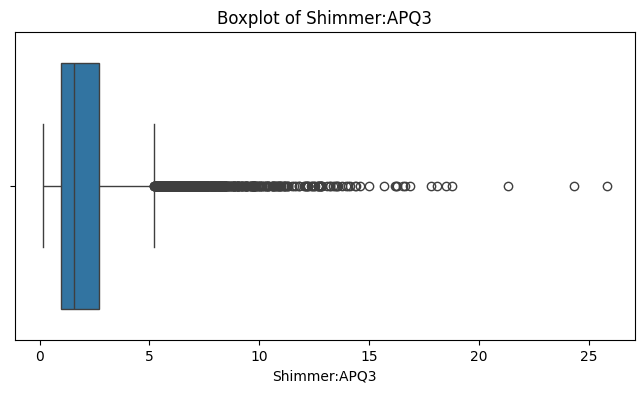

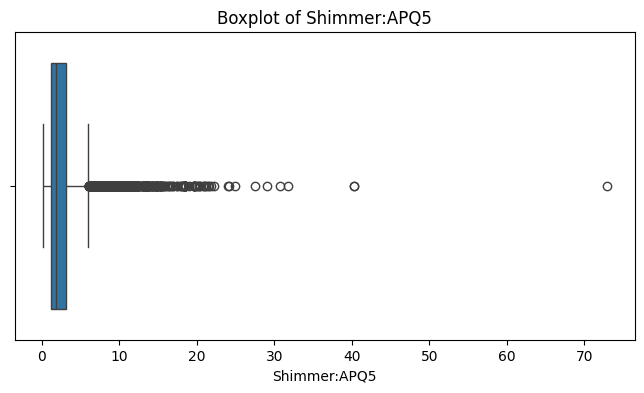

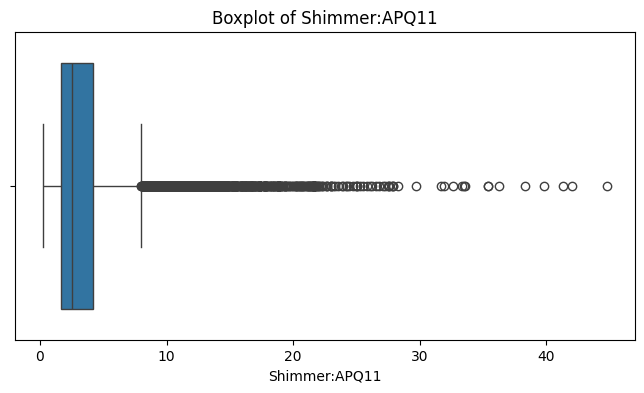

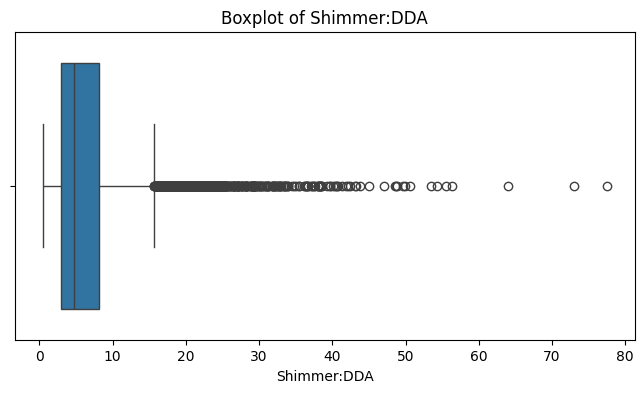

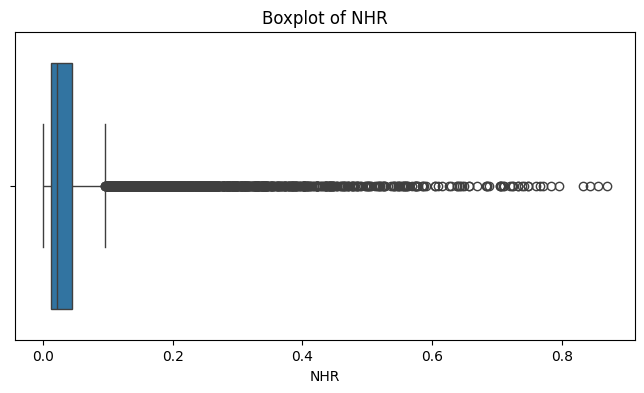

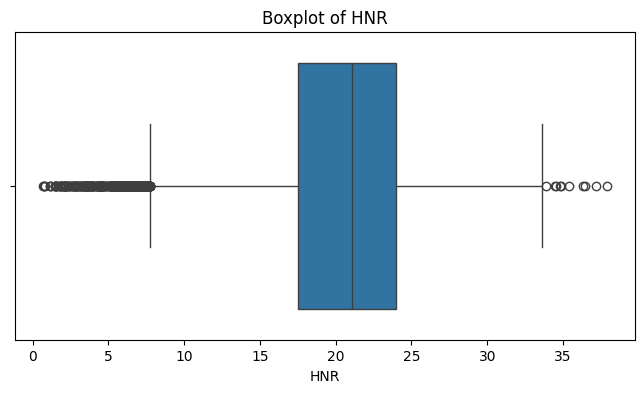

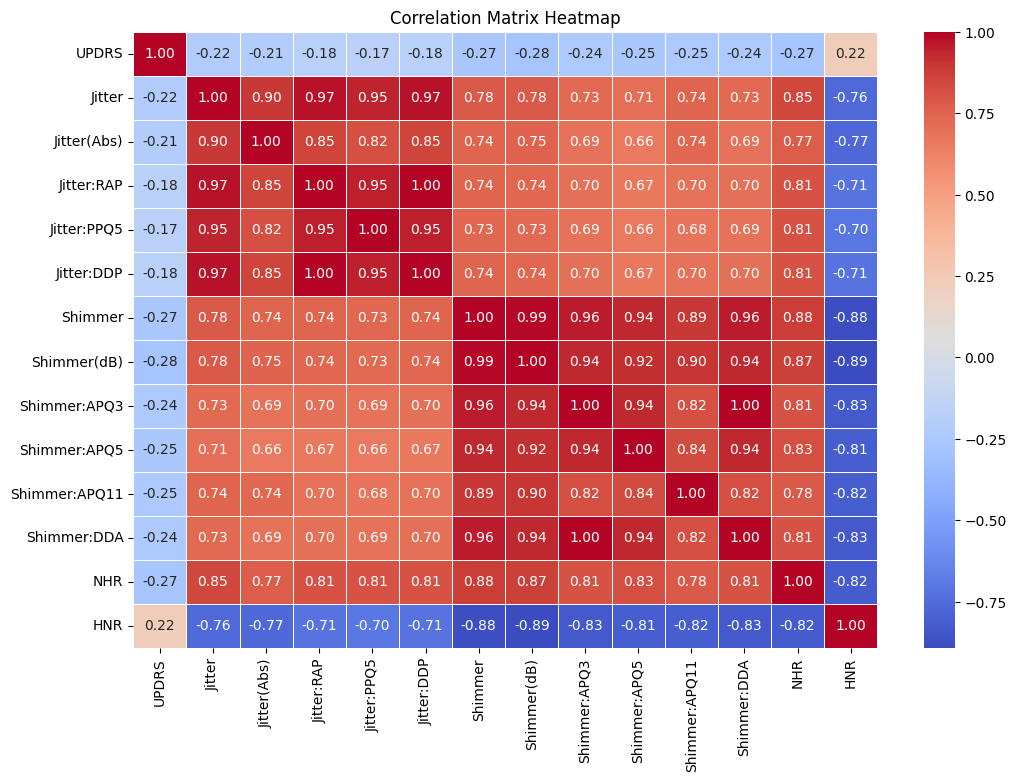

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# Load the dataset
file_path = '/content/drive/MyDrive/MINI PROJECT/TE_MSRtrain_combined (1).csv'
data = pd.read_csv(file_path)

# Dataset exploration and statistical measures
print("Dataset Information:")
data.info()
print(data.head())
print(data.describe())
print("Missing Values:\n", data.isnull().sum())
print("Class Distribution:\n", data['Class'].value_counts())

# Visualizing class imbalance
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=data)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Scatterplot between two important features and the target class
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Jitter', y='Shimmer', hue='Class', data=data)
plt.title('Scatterplot of Jitter vs Shimmer by Class')
plt.xlabel('Jitter')
plt.ylabel('Shimmer')
plt.show()

# Plotting histograms for all numerical features
data.hist(bins=20, figsize=(20, 15), color='blue', edgecolor='black')
plt.suptitle('Histograms of Features')
plt.show()

# List of features to plot (excluding 'Study', 'Subject', 'Class', 'UPDRS')
features = data.drop(columns=['Study', 'Subject', 'Class', 'UPDRS']).columns

# Plotting boxplots for each feature separately
for feature in features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[feature])
    plt.title(f'Boxplot of {feature}')
    plt.show()

# Selecting only the numeric columns and excluding the 'Class' column
numeric_data = data.select_dtypes(include=['number']).drop(columns=['Class'])

# Correlation matrix
corr_matrix = numeric_data.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

# Data preprocessing
X = data.drop(columns=['Study', 'Subject', 'Class', 'UPDRS'])
y = data['Class']

# Handle class imbalance (optional but recommended)
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, 'scaler.pkl')

# Model training
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)
best_rf_model = grid_search.best_estimator_

print(f"Best Parameters: {grid_search.best_params_}")
joblib.dump(best_rf_model, 'best_rf_model.pkl')

# Evaluate the model
y_train_pred = best_rf_model.predict(X_train_scaled)
y_test_pred = best_rf_model.predict(X_test_scaled)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
classification_rep = classification_report(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")
print("Classification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

# Feature importance
feature_importances = best_rf_model.feature_importances_
important_features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Cross-validation scores
cv_scores = cross_val_score(best_rf_model, X, y, cv=5, scoring='accuracy')
print(f"\nCross-Validation Accuracy: {cv_scores.mean() * 100:.2f}%")

# Prediction on unseen data
'''example_input = {
    'Jitter': 5.234, 'Jitter(Abs)': 0.0003091, 'Jitter:RAP': 2.145, 'Jitter:PPQ5': 2.812,
    'Jitter:DDP': 6.435, 'Shimmer': 12.657, 'Shimmer(dB)': 1.256, 'Shimmer:APQ3': 7.031,
    'Shimmer:APQ5': 9.583, 'Shimmer:APQ11': 12.548, 'Shimmer:DDA': 21.093, 'NHR': 0.348601, 'HNR': 6.842

}

# Convert the input dictionary to a DataFrame
input_df = pd.DataFrame([example_input])

# Align the input DataFrame with the columns used during training
input_df = input_df[X.columns]

# Scale the input data using the same scaler used for training
input_scaled = scaler.transform(input_df)

# Make a prediction
prediction = best_rf_model.predict(input_scaled)

# Output the result
print("Prediction:", "Parkinson's disease" if prediction[0] == 1 else "No Parkinson's disease")'''

# Example input for prediction
example_input = {
    'Jitter': 5.234, 'Jitter(Abs)': 0.0003091, 'Jitter:RAP': 2.145, 'Jitter:PPQ5': 2.812,
    'Jitter:DDP': 6.435, 'Shimmer': 12.657, 'Shimmer(dB)': 1.256, 'Shimmer:APQ3': 7.031,
    'Shimmer:APQ5': 9.583, 'Shimmer:APQ11': 12.548, 'Shimmer:DDA': 21.093, 'NHR': 0.348601, 'HNR': 6.842
}

# Convert the input dictionary to a DataFrame
input_df = pd.DataFrame([example_input])

# Align the input DataFrame with the columns used during training
input_df = input_df[X.columns]

# Debugging: Check the input before scaling
print("Input DataFrame before scaling:\n", input_df)

# Scale the input data using the same scaler used for training
input_scaled = scaler.transform(input_df)

# Debugging: Check the input after scaling
print("Input DataFrame after scaling:\n", input_scaled)

# Make a prediction
prediction = best_rf_model.predict(input_scaled)

# Output the result
print("Prediction:", "Parkinson's disease" if prediction[0] == 1 else "No Parkinson's disease")



In [ ]:
# Prediction on unseen data
example_input = {
    'Jitter': 5.234, 'Jitter(Abs)': 0.0003091, 'Jitter:RAP': 2.145, 'Jitter:PPQ5': 2.812,
    'Jitter:DDP': 6.435, 'Shimmer': 12.657, 'Shimmer(dB)': 1.256, 'Shimmer:APQ3': 7.031,
    'Shimmer:APQ5': 9.583, 'Shimmer:APQ11': 12.548, 'Shimmer:DDA': 21.093, 'NHR': 0.348601, 'HNR': 6.842

}

# Convert the input dictionary to a DataFrame
input_df = pd.DataFrame([example_input])

# Align the input DataFrame with the columns used during training
input_df = input_df[X.columns]

# Scale the input data using the same scaler used for training
input_scaled = scaler.transform(input_df)

# Make a prediction
prediction = best_rf_model.predict(input_scaled)

# Output the result
print("Prediction:", "Parkinson's disease" if prediction[0] == 1 else "No Parkinson's disease")
